### ***Установка библиотек***

In [ ]:
!pip install ortools osmnx -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.8/24.8 MB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 18.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.23.0 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.2.1 which is incompatible.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.2.1 which is incompatible.
tensorflow-metadata 1.14.0 requires absl-py<2.0.0,>=0.9, but you have absl-py 2.1.0 which is incompatible.
tensorflow-metadata 1.14.0 requires

### ***Импорт библиотек***

In [ ]:
import time
import math
import folium
import numpy as np
import osmnx as ox
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
# from tqdm import tqdm
from tqdm.notebook import trange, tqdm
# from ortools.constraint_solver import pywrapcp, routing_enums_pb2
# from ortools.graph.python import min_cost_flow, max_flow, linear_sum_assignment

### ***Загрузка и подготовка графа***

In [ ]:
def get_graph(city_id: str = 'R2555133') -> nx.Graph:
    # R1549169  Уфа
    # R2555133  Москва
    # R337422   Санкт-Петербург
    # R13470549 Аша
    # R41485    Рим
    # R6564910 Екатеринбург
    # R4676636 Курган
    gdf = ox.geocode_to_gdf(city_id, by_osmid=True)
    polygon_boundary = gdf.unary_union
    graph = ox.graph_from_polygon(polygon_boundary,
                                  network_type='drive',
                                  simplify=True)
    G = nx.Graph(graph)
    H = nx.Graph()
    # Добавляем рёбра в новый граф, копируя только веса
    for u, d in G.nodes(data=True):
        H.add_node(u, x=d['x'], y=d['y'])
    for u, v, d in G.edges(data=True):
        H.add_edge(u, v, length=d['length'])
    print('was created graph with', len(H.nodes()), 'nodes')
    del city_id, gdf, polygon_boundary, graph, G
    return H

### ***Визуалиация графа***


In [ ]:
def get_color_list(l:int):
    cmap = plt.get_cmap('plasma')
    colors = [cmap(i/l) for i in range(l)]
    hex_colors = ['#' + ''.join([f'{int(c*255):02x}' for c in color[:3]])\
          for color in colors]
    return hex_colors

In [ ]:
def get_color_list(l:int):
    cmap = plt.get_cmap('plasma')
    colors = [cmap(i/l) for i in range(l)]
    hex_colors = ['#' + ''.join([f'{int(c*255):02x}' for c in color[:3]])\
          for color in colors]
    return hex_colors
def draw_on_map(_G: nx.Graph,
                communities: tuple = None,
                m: folium.Map = None,
                node_colors: list | str = None,
                edge_colors :  str = 'black') -> folium.Map:
    if communities is None:
        communities = _G.nodes
    if node_colors is None:
        node_colors = get_color_list(len(communities))

    if m is None:
        for u, d in _G.nodes(data=True):
            u_x, u_y = d['x'], d['y']
            break
        m = folium.Map(location=[u_y, u_x], zoom_start=10)  # Координаты города
    for i, community in enumerate(communities):
        for node in community:
            if node not in _G.nodes():
                continue
            node_data = _G.nodes[node]
            popup_text = f"Кластер: {i}, \n" + f"номер: {node}"
            folium.CircleMarker(
                location=(node_data['y'], node_data['x']),
                radius=4,
                color=node_colors[i] if isinstance(node_colors, list) else node_colors,
                fill=True,
                fill_color=node_colors[i] if isinstance(node_colors, list) is list else node_colors,
                fill_opacity=0.7,
                popup=popup_text
            ).add_to(m)
    if not (edge_colors is None):
        for u, v, data in _G.edges(data=True):
            u_x, u_y = _G.nodes[u]['x'], _G.nodes[u]['y']
            v_x, v_y = _G.nodes[v]['x'], _G.nodes[v]['y']
            folium.PolyLine([(u_y, u_x), (v_y, v_x)], color=edge_colors, weight=1).add_to(m)
    return m

### ***Кластеризация***

In [ ]:
def extract_cluster_subgraph(graph, cluster_number):
    nodes_to_keep = [node for node, data in graph.nodes(data=True) if data['cluster'] == cluster_number]
    return graph.subgraph(nodes_to_keep)


def extract_cluster_list_subgraph(graph, cluster_number):
    nodes_to_keep = [node for node, data in graph.nodes(data=True) if data['cluster'] in cluster_number]
    return graph.subgraph(nodes_to_keep)

In [ ]:
def get_communities_and_clusters(H: nx.Graph, r=20):
    # Нахождение сообществ с помощью алгоритма Лувена
    communities = nx.community.louvain_communities(H,
                                                   seed=1534,
                                                   weight='length',
                                                   resolution=r)  # resolution - влияние на число кластеров увеличение числа и уменьшение размера при стремлении к 1
    for i, ids in enumerate(communities):
        for j in ids:
            H.nodes[j]['cluster'] = i
    clusters = [extract_cluster_subgraph(H, i) for i in range(len(communities))]
    print('Количество кластеров:\t', len(communities))
    return communities, clusters

In [ ]:
def get_cluster_to_neighboring_clusters(H: nx.Graph) -> dict:
    cls_to_neighboring_cls = {}
    for u, d in H.nodes(data=True):
        from_node = H.nodes[u]
        for v in H[u]:
            to_node = H.nodes[v]
            if to_node['cluster'] == from_node['cluster']:
                continue
            c1 = to_node['cluster']
            c2 = from_node['cluster']
            if not (c1 in cls_to_neighboring_cls):
                cls_to_neighboring_cls[c1] = set()
            if not (c2 in cls_to_neighboring_cls):
                cls_to_neighboring_cls[c2] = set()
            cls_to_neighboring_cls[c1].add(c2)
            cls_to_neighboring_cls[c2].add(c1)
    return cls_to_neighboring_cls


def get_cluster_to_bridge_points(H: nx.Graph) -> dict:
    cls_to_bridge_points = {}
    for u, d in H.nodes(data=True):
        from_node = H.nodes[u]
        for v in H[u]:
            to_node = H.nodes[v]
            if to_node['cluster'] == from_node['cluster']:
                continue
            c1 = to_node['cluster']
            c2 = from_node['cluster']

            if not (c1 in cls_to_bridge_points):
                cls_to_bridge_points[c1] = set()
            if not (c2 in cls_to_bridge_points):
                cls_to_bridge_points[c2] = set()
            cls_to_bridge_points[c1].add(u)
            cls_to_bridge_points[c2].add(v)
    return cls_to_bridge_points


def get_cluster_to_centers(X: nx.Graph):
    cls_to_center = {d['cluster']: u for u, d in X.nodes(data=True)}
    return cls_to_center


def get_path_graph(_G: nx.Graph, path):
    P = nx.Graph()
    g_nodes = _G.nodes(data=True)
    nodes = path[1]
    for u in nodes:
        P.add_node(u, x=g_nodes[u]['x'], y=g_nodes[u]['y'])
    for i in range(len(nodes) - 1):
        P.add_edge(nodes[i], nodes[i + 1])
    return P


нужно попробовать находить центр кластера и использоавть их для нахождения дистанций между кластерами


In [ ]:
def get_path_len(d: dict, cluster_to_bridge_points, cls: int, p=1):
    res_len = 0
    for u in cluster_to_bridge_points[cls]:
        if u in d and d[u] > 0:
            res_len += d[u] ** p
    if res_len > 0:
        return res_len ** (1 / p)
    return 0


def build_center_graph(
        G: nx.Graph,
        communities: tuple | list,
        sub_graphs: list,
        cluster_to_bridge_points: dict,
        cluster_to_neighboring_cluster: dict,
        p: int = 1,
        use_all_point = True):
    """
        строим граф центройд по комьюнити для графа G
    """
    centers = {}
    X = nx.Graph()
    for cls, d in tqdm(enumerate(communities), desc='создание центройд',total=len(communities)):
        gc = sub_graphs[cls]
        _p = dict(nx.all_pairs_dijkstra_path_length(gc, weight = 'length'))
        if use_all_point:
            dist = {u: get_path_len(_p[u], communities, cls, p) for u in _p}
        else:
            dist = {u: get_path_len(_p[u], cluster_to_bridge_points, cls, p) for u in _p}

        min_path = 10000000
        min_node = 0
        for u in dist:
            d = dist[u]
            if d < min_path:
                min_path = d
                min_node = u
        du = G.nodes(data=True)[min_node]
        X.add_node(min_node, **du)
        centers[cls] = min_node

    for u, d in X.nodes(data=True):
        for v in cluster_to_neighboring_cluster[d['cluster']]:
            l = nx.single_source_dijkstra(G, source=u, target=centers[v], weight='length')[0]
            X.add_edge(u, centers[v], length=l)
    return X


In [ ]:
import random
import time
from tqdm.notebook import trange, tqdm

def get_node(H: nx.Graph, cls_to_center:dict, X: nx.Graph):
    node_from = random.choice(list(H.nodes()))
    node_to =   random.choice(list(H.nodes()))
    # c_from = H.nodes(data=True)[node_from]['cluster']
    # c_to= H.nodes(data=True)[node_to]['cluster']

    l = nx.single_source_dijkstra(H, node_from, node_to, weight='length')
    c = set()
    for u in l[1]:
        c.add(H.nodes[u]['cluster'])
    while len(c) < 10:
        node_from = random.choice(list(H.nodes()))
        node_to =   random.choice(list(H.nodes()))
        # c_from = H.nodes(data=True)[node_from]['cluster']
        # c_to= H.nodes(data=True)[node_to]['cluster']

        l = nx.single_source_dijkstra(H, node_from, node_to, weight='length')
        c.clear()
        for u in l[1]:
            c.add(H.nodes[u]['cluster'])
    return node_from, node_to

In [ ]:
def find_path(
        H: nx.Graph,
        from_node: int,
        to_node: int,
        cls_to_center: dict,
        communities: list = None,
        X: nx.Graph = None,
        cluster_to_neighboring_cluster=None) -> tuple:
    if X is None or communities is None:
        return nx.single_source_dijkstra(H, from_node, to_node, weight='length')

    from_d = H.nodes[from_node]
    to_d = H.nodes[to_node]

    from_cluster = from_d['cluster']
    to_cluster = to_d['cluster']

    if from_cluster == to_cluster:
        return nx.single_source_dijkstra(extract_cluster_list_subgraph(H, [to_cluster]), from_node, to_node,
                                         weight='length')

    from_center = cls_to_center[from_cluster]
    to_center = cls_to_center[to_cluster]

    path = nx.bidirectional_dijkstra(
        X,
        from_center,
        to_center,
        weight='length')
    cls = set()
    for u in path[1]:
        c = X.nodes[u]['cluster']
        cls.add(c)
        # for to in cluster_to_neighboring_cluster[c]:
        #     cls.add(to)
    return nx.bidirectional_dijkstra(
        extract_cluster_list_subgraph(H, cls),
        from_node,
        to_node,
        weight='length')


In [ ]:
class pRes:
    def __init__(self):
        self.r = 0
        self.clusters = 0
        self.k = 0
        self.err_rel = []
        self.speed_up = []
        self.path_len = []


In [ ]:
class LayerGraphInfo:
    def __init__(self, H: nx.Graph, r: float = 20):
        self.graph = H
        self.resolution = r
        self.communities, self.sub_graphs = get_communities_and_clusters(self.graph, self.resolution)
        self.cluster_to_neighboring_cluster = get_cluster_to_neighboring_clusters(self.graph)
        self.cluster_to_bridge_points = get_cluster_to_bridge_points(self.graph)

        self.center_graph = build_center_graph(
            self.graph,
            self.communities,
            self.sub_graphs,
            self.cluster_to_bridge_points,
            self.cluster_to_neighboring_cluster)

        self.cluster_to_center = get_cluster_to_centers(self.center_graph)

    def draw_graph(self):
        return draw_on_map(self.graph, self.communities)


    def draw_center_graph(self):
        return draw_on_map(self.graph, self.communities)


In [ ]:
class HierarchicalStructure:
    def __init__(self, H: nx.Graph, layers: int = 1, resolution: int | list = 20):
        if type(resolution) is list or type(resolution) is tuple:
            assert len(resolution) == layers
        else:
            resolution = [resolution] * layers
        self.layers = []
        for i in tqdm(range(layers), desc='создание слоев', total = layers):
            if i == 0:
                self.layers.append(LayerGraphInfo(H, resolution[i]))
            else:
                self.layers.append(LayerGraphInfo(self.layers[i - 1].center_graph, resolution[i]))
    def draw_graph(self, layer: int):
        return self.layers[layer].draw_graph()

    def draw_center_graph(self,layer: int):
        return self.layers[layer].draw_center_graph()
    def find_path(self):
        pass

In [ ]:
def find_path(
        layer: LayerGraphInfo,
        from_node: int,
        to_node: int) -> tuple:
    from_d = layer.graph.nodes[from_node]
    to_d = layer.graph.nodes[to_node]

    from_cluster = from_d['cluster']
    to_cluster = to_d['cluster']

    if from_cluster == to_cluster:
        return nx.single_source_dijkstra(extract_cluster_subgraph(layer.graph, to_cluster), from_node, to_node,
                                         weight='length')

    from_center = layer.cluster_to_center[from_cluster]
    to_center = layer.cluster_to_center[to_cluster]

    path = nx.bidirectional_dijkstra(
        layer.center_graph,
        from_center,
        to_center,
        weight='length')
    cls = set()
    for u in path[1]:
        c = layer.center_graph.nodes[u]['cluster']
        cls.add(c)
        for to in layer.cluster_to_neighboring_cluster[c]:
            cls.add(to)
    return nx.bidirectional_dijkstra(
        extract_cluster_list_subgraph(layer.graph, cls),
        from_node,
        to_node,
        weight='length')

### ***TESTS:***



In [ ]:
H = get_graph()

was created graph with 17718 nodes


In [ ]:
print(len(H.nodes()))
print(len(H.edges))

17718
26747


In [ ]:
# resolutions = [100]
resolutions = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,30,40,50]#,25,30, 40, 50,100]

for r in tqdm(resolutions, desc='tests'):
    layer = LayerGraphInfo(H, r)
    print(len(layer.center_graph.nodes()),' ',len(layer.center_graph.edges))

tests:   0%|          | 0/19 [00:00<?, ?it/s]

Количество кластеров:	 146


создание центройд:   0%|          | 0/146 [00:00<?, ?it/s]

146   412
Количество кластеров:	 212


создание центройд:   0%|          | 0/212 [00:00<?, ?it/s]

212   597
Количество кластеров:	 275


создание центройд:   0%|          | 0/275 [00:00<?, ?it/s]

275   759
Количество кластеров:	 317


создание центройд:   0%|          | 0/317 [00:00<?, ?it/s]

317   881
Количество кластеров:	 354


создание центройд:   0%|          | 0/354 [00:00<?, ?it/s]

354   993
Количество кластеров:	 392


создание центройд:   0%|          | 0/392 [00:00<?, ?it/s]

392   1093
Количество кластеров:	 416


создание центройд:   0%|          | 0/416 [00:00<?, ?it/s]

416   1151
Количество кластеров:	 448


создание центройд:   0%|          | 0/448 [00:00<?, ?it/s]

448   1245
Количество кластеров:	 482


создание центройд:   0%|          | 0/482 [00:00<?, ?it/s]

482   1328
Количество кластеров:	 514


создание центройд:   0%|          | 0/514 [00:00<?, ?it/s]

514   1400
Количество кластеров:	 540


создание центройд:   0%|          | 0/540 [00:00<?, ?it/s]

540   1478
Количество кластеров:	 566


создание центройд:   0%|          | 0/566 [00:00<?, ?it/s]

566   1542
Количество кластеров:	 574


создание центройд:   0%|          | 0/574 [00:00<?, ?it/s]

574   1573
Количество кластеров:	 603


создание центройд:   0%|          | 0/603 [00:00<?, ?it/s]

603   1638
Количество кластеров:	 626


создание центройд:   0%|          | 0/626 [00:00<?, ?it/s]

626   1718
Количество кластеров:	 738


создание центройд:   0%|          | 0/738 [00:00<?, ?it/s]

738   1985
Количество кластеров:	 914


создание центройд:   0%|          | 0/914 [00:00<?, ?it/s]

914   2426
Количество кластеров:	 1038


создание центройд:   0%|          | 0/1038 [00:00<?, ?it/s]

1038   2716
Количество кластеров:	 1161


создание центройд:   0%|          | 0/1161 [00:00<?, ?it/s]

1161   2996


514
1400


In [ ]:
import time
from tqdm.notebook import trange, tqdm

# resolutions = [100]
resolutions = [30,40,50]#,25,30, 40, 50,100]
N : int = 200

results = {r : None for r in resolutions}

for r in tqdm(resolutions, desc='tests'):
    results[r] = pRes()
    layer = LayerGraphInfo(H, r)
    results[r].clusters = len(layer.communities)
    results[r].k = len(H.nodes())/len(layer.communities)

    points = [get_node(layer.graph, layer.cluster_to_center,layer.center_graph) for i in trange(N, desc='generate points')]
    for i in trange(N, desc='test for resolution={0:.1f}'.format(r)):
        node_from, node_to = points[i]

        start_time = time.time()
        usual_path = nx.single_source_dijkstra(H, node_from, node_to,weight='length')
        usual_time = time.time() - start_time

        start_time = time.time()
        my_path = find_path(layer, node_from, node_to)
        my_time = time.time() - start_time


        speed_up = usual_time / my_time
        err_rel = ((my_path[0] - usual_path[0])/usual_path[0])
        res = results[r]

        res.speed_up.append(speed_up)
        res.path_len.append(usual_path[0])
        res.err_rel.append(err_rel)

tests:   0%|          | 0/3 [00:00<?, ?it/s]

Количество кластеров:	 914


создание центройд:   0%|          | 0/914 [00:00<?, ?it/s]

generate points:   0%|          | 0/200 [00:00<?, ?it/s]

test for resolution=30.0:   0%|          | 0/200 [00:00<?, ?it/s]

Количество кластеров:	 1038


создание центройд:   0%|          | 0/1038 [00:00<?, ?it/s]

generate points:   0%|          | 0/200 [00:00<?, ?it/s]

test for resolution=40.0:   0%|          | 0/200 [00:00<?, ?it/s]

Количество кластеров:	 1161


создание центройд:   0%|          | 0/1161 [00:00<?, ?it/s]

generate points:   0%|          | 0/200 [00:00<?, ?it/s]

test for resolution=50.0:   0%|          | 0/200 [00:00<?, ?it/s]

box plot - ускорение относительно ошибки
Оценить в O(n)




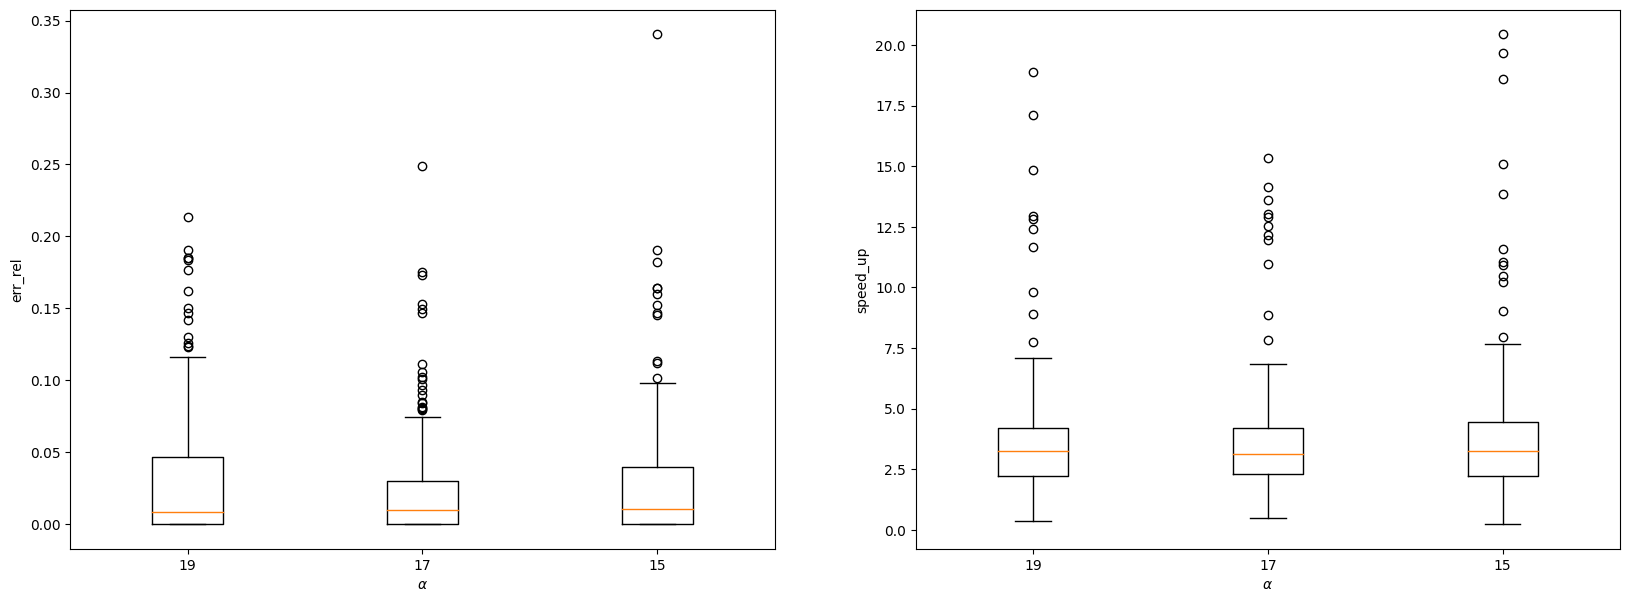

In [ ]:
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(20)
fig.set_figheight(7)

labels = ['{0:.0f}'.format(len(H.nodes())/results[r].clusters) for r in resolutions]
data1 = [results[r].err_rel for r in resolutions]
data2 = [results[r].speed_up for r in resolutions]

# Creating plot
b1 = axs[0].boxplot(data1, labels=labels)
b1 = axs[1].boxplot(data2, labels=labels)

axs[0].set(xlabel=r'$\alpha$', ylabel='err_rel')
axs[1].set(xlabel=r'$\alpha$', ylabel='speed_up')

plt.savefig('drive/MyDrive/clusters_results/Msk_box_plot3.png')
# show plot
plt.show()

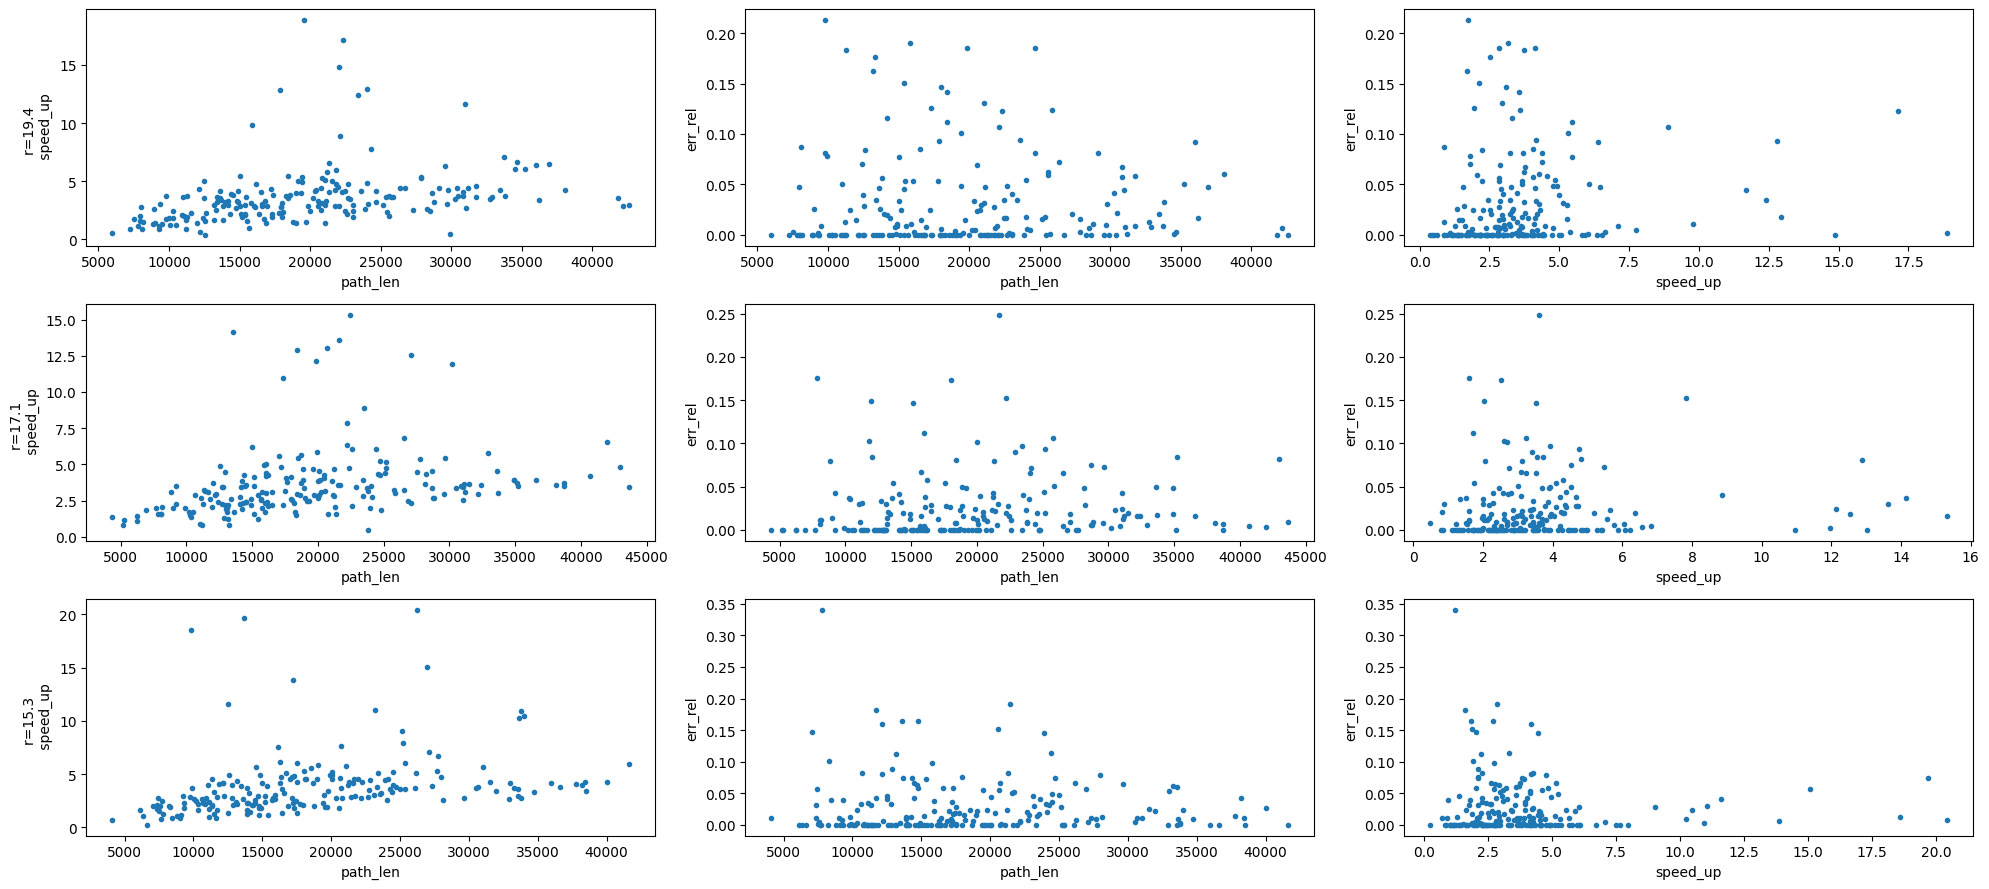

In [ ]:
x = [i for i in range(N)]
def max(a,b):
    if a>b:
        return a
    else:
        return b
fig, axs = plt.subplots(max(len(resolutions),2),3)
fig.set_figwidth(20)
fig.set_figheight(3 * max(len(resolutions),2))

for i,r in enumerate(resolutions):
    res = results[r]
    axs[i,0].plot(res.path_len,res.speed_up,'.')
    axs[i,0].set(ylabel='r={0:.1f} \n speed_up'.format(len(H.nodes())/results[r].clusters), xlabel='path_len')
    # start, end = axs[i,0].get_xlim()
    # axs[i,0].xaxis.set_ticks(np.arange(0, round(end), 2))
    axs[i,1].plot(res.path_len,res.err_rel,'.')
    axs[i,1].set(xlabel='path_len', ylabel='err_rel')

    axs[i,2].plot(res.speed_up,res.err_rel,'.')
    axs[i,2].set(xlabel='speed_up', ylabel='err_rel')

plt.savefig('drive/MyDrive/clusters_results/Msk_plots3.png')

fig.tight_layout()

In [ ]:
import numpy as np
err_mean = []
err_min = []
err_max = []

speed_up_mean = []
speed_up_min = []
speed_up_max = []

for i,r in enumerate(resolutions):
    res = results[r]
    print(r)
    print('speed up:','{0:.4f}'.format(np.mean(res.speed_up)),u"\u00B1",'{0:.4f}'.format(np.std(res.speed_up)))
    print('err_rel:','{0:.4f}'.format(np.mean(res.err_rel)),u"\u00B1",'{0:.4f}'.format(np.std(res.err_rel)))

    err_mean.append('{0:.4f}'.format(np.mean(res.err_rel)) + u"\u00B1" + '{0:.4f}'.format(np.std(res.err_rel)))
    err_min.append('{0:.4f}'.format(np.min(res.err_rel)))
    err_max.append('{0:.4f}'.format(np.max(res.err_rel)))

    speed_up_mean.append('{0:.4f}'.format(np.mean(res.speed_up))+u"\u00B1"+'{0:.4f}'.format(np.std(res.speed_up)))
    speed_up_min.append('{0:.4f}'.format(np.min(res.speed_up)))
    speed_up_max.append('{0:.4f}'.format(np.max(res.speed_up)))


30
speed up: 3.6547 ± 2.5820
err_rel: 0.0304 ± 0.0455
40
speed up: 3.6597 ± 2.4343
err_rel: 0.0244 ± 0.0374
50
speed up: 3.8425 ± 2.9250
err_rel: 0.0278 ± 0.0442


In [ ]:
# cls = set()
# for u in paths[1]:
#     c = H.nodes[u]['cluster']
#     cls.add(c)
# for u in paths[0]:
#     c = H.nodes[u]['cluster']
#     cls.add(c)
#     # for to in cluster_to_neighboring_cluster[c]:
#     #     cls.add(to)
# _m = None
# _m = draw_on_map(extract_cluster_list_subgraph(H, cls), communities,m = _m,)
# # _m = None
# _m = draw_on_map(p[0], communities, m = _m, node_colors = 'red', edge_colors = 'red' )
# _m = draw_on_map(p[1], communities, m = _m, node_colors = 'green', edge_colors = 'green' )
# # _m = draw_on_map(extract_cluster_list_subgraph(H,[d['cluster'] for u,d in H.nodes(data=True) if u in p[0].nodes()]), communities, m = _m)
# _m

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
q = [u for u,d in H.nodes(data=True) if d['cluster'] == 417]
print(len(q))

8


In [ ]:
!pip install xlsxwriter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 3.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd

data = {'resolutions': resolutions,
        'err_mean': err_mean,
        'err_min': err_min,
        'err_max': err_max,
        'speedup_mean': speed_up_mean,
        'speedup_min': speed_up_min,
        'speedup_max': speed_up_max,
        'clusters': [results[r].clusters for r in results],
        'k':'{0:.1f}'.format([results[r].k for r in results])
        }
df = pd.DataFrame.from_dict(data)
# create a pandas.ExcelWriter object
writer = pd.ExcelWriter('drive/MyDrive/clusters_results/Msk_5000_points.xlsx', engine='xlsxwriter')

# write the data frame to Excel
df.to_excel(writer, index=False, sheet_name='Sheet1')

# get the XlsxWriter workbook and worksheet objects
workbook = writer.book
worksheet = writer.sheets['Sheet1']

# adjust the column widths based on the content
for i, col in enumerate(df.columns):
    width = max(df[col].apply(lambda x: len(str(x)) + 1).max(), len(col))
    worksheet.set_column(i, i, width)

# save the Excel file
writer.close()

In [ ]:
# Assigns colors (starting from 0) to all
# vertices and prints the assignment of colors
def greedyColoring(G : nx.Graph, v: int):

    result = {u : -1 for u in G.nodes()}
    available = [False] * v

    for u in G.nodes():
        for i in G[u]:
            if result[i] != -1:
                available[result[i]] = True

        # Find the first available color
        cr = 0
        while cr < v:
            if (available[cr] == False):
                break

            cr += 1

        # Assign the found color
        result[u] = cr

        # Reset the values back to false
        # for the next iteration
        for i in G[u]:
            if (result[i] != -1):
                available[result[i]] = False
    return result


In [ ]:
colors = greedyColoring(H, len(H.nodes))
l = [colors[k] for k in colors]
cls = ['#FFA07A', '#8B0000', '#FF1493', '#FF4500','#6A5ACD', '#E6E6FA','#00FF00','#0000FF']
colors_list = get_color_list(max(l) + 1)
l = [cls[colors[k]] for k in colors]

_m = draw_on_map(H, communities, node_colors = l)
_m